#Active Learning over random labeling


Uncertainty Sampling with
least confidence
minimum margin
entropy criterion

Query-by-Committee with
vote entropy
consensus entropy
maximum disagreement

Expected Model Change for gradient-based learning including a simple polynomial classification model Density weighting with KDEs

Ref: https://www.inovex.de/de/blog/intro-to-active-learning/

Package imports

In [ ]:
%pylab inline

from typing import Callable, Sequence, Tuple, Optional
from random import sample

from sklearn.linear_model import LogisticRegression
from scipy.stats import multivariate_normal, ortho_group
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [ ]:
sns.set_style("white")
colors = sns.color_palette(n_colors=10)

Sample 2d data from two Gaussians
The means are chosen to make the data is linearly separable.

Move the gaussians closer together to see how active learning would deal with non-linearly separable data.
Play with the seeds to get different shapes of the gaussians.

In [ ]:
def sample_covar(dim: int = 2, scale_min: float =  .3, scale_max: float = 5) -> np.ndarray:
  """Construct random covariance matrix by sampling a rotation and scale matrix."""
  R = ortho_group.rvs(dim) * (rand(dim, dim) * (scale_max - scale_min) + scale_min)
  return R.dot(R.T)

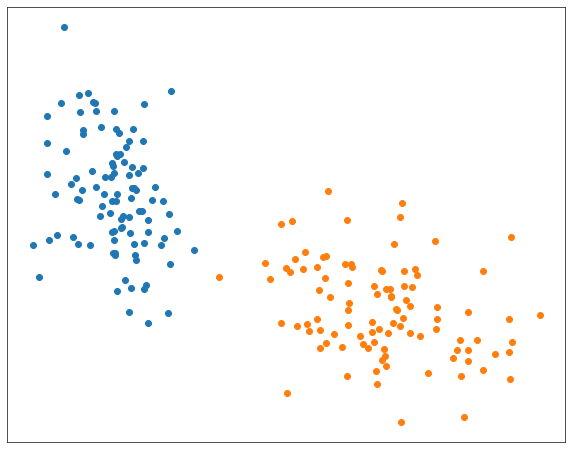

In [ ]:
N_1, N_2 = 100, 100  # number of samples in each point cloud
mu_1 = [-5, 2]  # centroid of the first point cloud
mu_2 = [5, -2]  # centroid of the second point cloud

random.seed(23)

X = np.concatenate([
  multivariate_normal(mu_1, sample_covar()).rvs(N_1),
  multivariate_normal(mu_2, sample_covar()).rvs(N_2),
])
y = np.concatenate([zeros(N_1, int), ones(N_2, int)])

# show a scatter plot of the data
figure(figsize=(10,8))
scatter(X[y==0, 0], X[y==0, 1], color=colors[0])
scatter(X[y==1, 0], X[y==1, 1], color=colors[1])
xticks(()), yticks(());

Helper functions for plotting data and classifier

In [ ]:
def meshgrid_from_bounds(lower_left: Sequence[float], upper_right: Sequence[float], *,
                         resolution: float = 0.02) -> Tuple[np.ndarray, np.ndarray]:
  """Return a meshgrid that covers the range from lower_left to upper_right."""
  return meshgrid(arange(lower_left[0], upper_right[0], resolution),
                  arange(lower_left[1], upper_right[1], resolution))

def plot_decision_boundary(clf, lower_left: Sequence[float], upper_right: Sequence[float], *,
                           resolution: float = 0.02, boundary_color: Tuple[float] = (0.2, 0.2, 0.2)):
  """Plot decision boundary of a given classifier in the given range.
  
     Args:
        clf: The classifier to evaluate.
        lower_left: Lower left coordinate of the plotting range.
        upper_right: Upper right coordinate of the plotting range.
  """
  xx, yy = meshgrid_from_bounds(lower_left, upper_right, resolution=resolution)
  Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0].reshape(xx.shape)
  contour(xx, yy, Z, levels=[0.5], colors=[boundary_color])

def lighten(color: Tuple[float], *, amount: float = .6):
  """Blend color with white by the given amount."""
  return tuple(array(color) * (1 - amount) + array([1, 1, 1]) * amount)

In [ ]:
def plot_data(X: np.ndarray, y: np.ndarray, train_idx: Sequence[int], *,
              colors: Sequence[Tuple[float]] = sns.color_palette(n_colors=2)):
  """Scatter plot of the training and unlabeled data.

     Args:
        X, y: Data and associated labels.
        train_idx: Indices of the training data.
        colors: Plotting colors of the two classes."""
  # show all data
  scatter(X[y==0, 0], X[y==0, 1], color=lighten(colors[0]), s=6)
  scatter(X[y==1, 0], X[y==1, 1], color=lighten(colors[1]), s=6)

  # show training data
  X_tr = X[train_idx]
  y_tr = y[train_idx]
  scatter(X_tr[y_tr==0, 0], X_tr[y_tr==0, 1], color=colors[0])
  scatter(X_tr[y_tr==1, 0], X_tr[y_tr==1, 1], color=colors[1])
  xticks(()), yticks(());

def plot_data_and_classifier(X: np.ndarray, y: np.ndarray, train_idx: Sequence[int], clf, *,
                             previous_clf=None, colors: Sequence[Tuple[float]] = sns.color_palette(n_colors=2)):
  """Scatter plot of the training and unlabeled data and the decision boundary of the classifier.

     Also draws decsion boundary of the classifier from the previous round (if given).

     Args:
        X, y: Data and associated labels.
        train_idx: Indices of the training data.
        clf: Classifier trained on training data.
        pervious_clf: Classifier trained on training data in the last round.
        colors: Plotting colors of the two classes.
  """
  if previous_clf is not None:
    plot_decision_boundary(previous_clf, lower_left=X.min(axis=0) - 1, upper_right=X.max(axis=0) + 1, boundary_color=(0.7, 0.7, 0.7))

  plot_decision_boundary(clf, lower_left=X.min(axis=0) - 1, upper_right=X.max(axis=0) + 1)
  plot_data(X, y, train_idx, colors=colors)

Non-active learning
Train a logistic regression classifier on 10 randomly sampled training examples.

Note: we cherry-picked an example where the training went wrong - play with the seed (or remove it) to see different results.

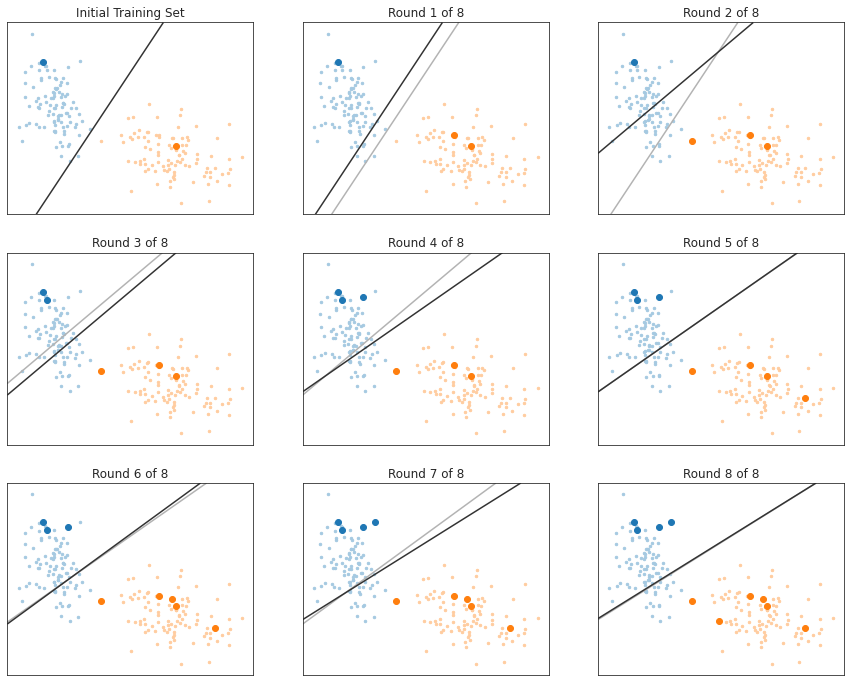

In [ ]:
random.seed(112818)  # cherry-pick a seed of a bad example

# start with one sample from either class
starting_samples = [choice(range(N_1)), N_1 + choice(range(N_2))]
train_idx = starting_samples[:]
clf = LogisticRegression().fit(X[train_idx], y[train_idx])

# ...  and randomly sample 8 additional training samples
figure(figsize=(15, 12))
subplot(3, 3, 1)
title(f'Initial Training Set')
plot_data_and_classifier(X, y, train_idx, clf)

for round in range(8):
  new_sample = choice([i for i in range(N_1 + N_2) if i not in train_idx])
  train_idx.append(new_sample)
  previous_clf = clf
  clf = LogisticRegression().fit(X[train_idx], y[train_idx])
  
  ax = subplot(3, 3, round+2)
  title(f'Round {round + 1} of 8')
  plot_data_and_classifier(X, y, train_idx, clf, previous_clf=previous_clf)

Active learning with uncertainty sampling
Starting with one sample from either class as above, iteratively get the label of a sample where the model is most uncertain about the class until 10 samples are drawn.

In [ ]:
from scipy.stats import entropy

def least_confidence(posterior: np.ndarray) -> np.ndarray:
  """Least confidence criterion, u(x) = 1 - max P(y | x).

     Args:
        posterior: Estimated class probabilities - ndarray of shape (n_samples, n_classes).
    
     Returns:
        Least-confidence score.
  """
  return 1 - posterior.max(axis=1)


def minimum_margin(posterior: np.ndarray) -> np.ndarray:
  """Minumum margin criterion, u(x) = P(y_2* | x) - P(y_1* | x), where y_1* and y_2* are the two most probable classes.

     Args:
        posterior: Estimated class probabilities - ndarray of shape (n_samples, n_classes).
    
     Returns:
        Minumum margin score.
  """
  most_probable = posterior.max(axis=1)
  # hack to get the second highest posterior probability
  mask_most_probable = (posterior == most_probable.reshape(-1, 1))
  second_most_probable = (posterior - mask_most_probable).max(axis=1)
  return second_most_probable - most_probable


def entropy_criterion(posterior: np.ndarray) -> np.ndarray:
  """Entropy criterion, u(x) = -E[log P(y | x)].

     Args:
        posterior: Estimated class probabilities - ndarray of shape (n_samples, n_classes).
    
     Returns:
        Entropy of the posterior distribution.
  """
  return entropy(posterior, axis=1)


def uncertainty_sampling(clf, X: np.ndarray, train_idx: Sequence[int], criterion: Callable[[np.ndarray], np.ndarray]) -> int:
  """Get the index of an unknown sample where the classifier is most uncertain about the label.

     Args:
        clf: The classifier (must provide `predict_proba()`).
        X: All data (labeled and unlabeled) - ndarray of shape (n_samples, n_features).
        train_idx: Indices of the training samples.
        criterion: Sample utility that maps posterior class probabilities to sample utility.

     Returns:
        Index of the sample in X with the highest decision uncertainty that is not yet in `train_idx`.
  """
  unknown_indices = array([i for i in range(X.shape[0]) if i not in train_idx])
  posterior = clf.predict_proba(X[unknown_indices])
  utility = criterion(posterior)
  return unknown_indices[argmax(utility)]

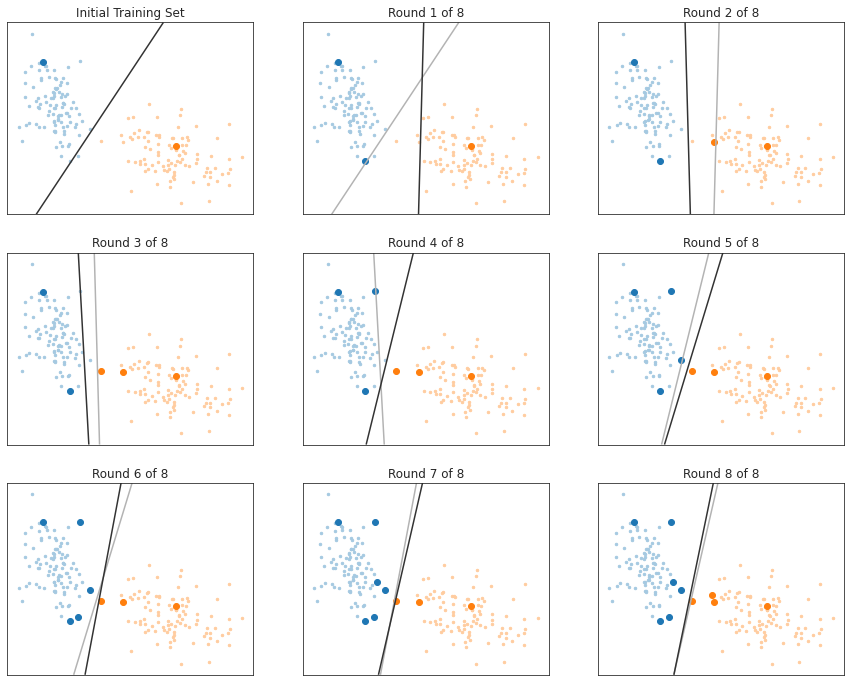

In [ ]:
# starting with the sample samples as above ...
train_idx = starting_samples[:]
clf = LogisticRegression().fit(X[train_idx], y[train_idx])

figure(figsize=(15, 12))
subplot(3, 3, 1)
title(f'Initial Training Set')
plot_data_and_classifier(X, y, train_idx, clf)

# ... do 8 rounds of uncertainty sampling
for round in range(8):
  new_sample = uncertainty_sampling(clf, X, train_idx, criterion=entropy_criterion)
  train_idx.append(new_sample)

  subplot(3, 3, round+2)
  title(f'Round {round + 1} of 8')
  previous_clf = clf
  clf = LogisticRegression().fit(X[train_idx], y[train_idx])
  plot_data_and_classifier(X, y, train_idx, clf, previous_clf=previous_clf)